*This notebook was developed by Marina Ricci for the DESC CL_Cosmo_Pipeline team.*
## This notebook aims at presenting the stage that bins cluster in richness/redshift bins. We will see how to run the code from the notebook (I) or in pipeline mode (II).

It is meant to be run independently. If you already produced the necessary outputs `ceci` will use them, and otherwise create them.
___

In [1]:
import os
from pprint import pprint
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
import ceci
import h5py
import yaml

Make sure to change your path in the next cell that leads to your TXPipe directory. See examples for IN2P3 and NERSC below.

In [2]:
# user specific paths -- IN2P3 example
my_txpipe_dir = "/pbs/home/m/mricci/throng_mricci/desc/TXPipe"
#my_txpipe_dir = "/pbs/throng/lsst/users/ccombet/TXPipe"

# user specific paths -- NERSC example
# my_txpipe_dir = "/pscratch/sd/a/avestruz/TXPipe"

os.chdir(my_txpipe_dir)

import txpipe

___

# I - Let's start working with the 1deg2 data file on Jupyter

First we will do some runs on the 1 deg^2 example data set with around 80k galaxies. This is small enough that we can do it all in jupyter.

The data set, which is based on CosmoDC2, contains pre-computed photo-z and and contains a RedMapper cluster catalog for the field.

In [23]:
print("Options for this pipeline and their defaults (this may be override by config file):")
print(txpipe.extensions.CLClusterBinningRedshiftRichness.config_options)

pip_stage = txpipe.extensions.CLClusterBinningRedshiftRichness.make_stage(
    # This is the initial cluster catalog - RAs, Decs, richess, redshift, etc.
    cluster_catalog="./data/example/inputs/cluster_catalog.hdf5",
    
    # This is the output for this stage 
    cluster_catalog_tomography="./data/cosmodc2/outputs-1deg2-CL/cluster_catalog_tomography.hdf5",

    # This contains all the options for this stage. You can override them here.
    config="examples/cosmodc2/Cluster_pipelines/config-1deg2-CL.yml",    
)

Options for this pipeline and their defaults (this may be override by config file):
{'zedge': [0.2, 0.4, 0.6, 0.8, 1.0], 'richedge': [5.0, 10.0, 20.0], 'initial_size': 100000, 'chunk_rows': 100000}


In [24]:
pip_stage.run()
pip_stage.finalize()

In [25]:
print("Actual options used for this pipeline (as defined in config file or default):")
print(pip_stage.config)

Actual options used for this pipeline (as defined in config file or default):
{zedge:[0.2, 0.4, 0.6, 0.8],richedge:[5.0, 10.0, 100.0],initial_size:100000,chunk_rows:100000,cluster_catalog:./data/example/inputs/cluster_catalog.hdf5,cluster_catalog_tomography:./data/cosmodc2/outputs-1deg2-CL/cluster_catalog_tomography.hdf5,config:examples/cosmodc2/Cluster_pipelines/config-1deg2-CL.yml,}


In [26]:
pip_stage.config['cluster_catalog']

'./data/example/inputs/cluster_catalog.hdf5'

In [27]:
pip_stage.config['cluster_catalog_tomography']

'./data/cosmodc2/outputs-1deg2-CL/cluster_catalog_tomography.hdf5'

## Open cluster catalog input and compare to binning outputs

### Open cluster catalog input 

In [28]:
filename_in = pip_stage.config['cluster_catalog']
print(filename_in)

./data/example/inputs/cluster_catalog.hdf5


In [29]:
f_in = h5py.File(filename_in, "r")

In [30]:
print(f_in.keys())

<KeysViewHDF5 ['clusters', 'provenance']>


In [31]:
dset_in = f_in['clusters']

In [32]:
cols = [col for col in dset_in]
print(cols)

['cluster_id', 'dec', 'ra', 'redshift', 'redshift_err', 'richness', 'richness_err', 'scaleval']


Text(0, 0.5, 'richness')

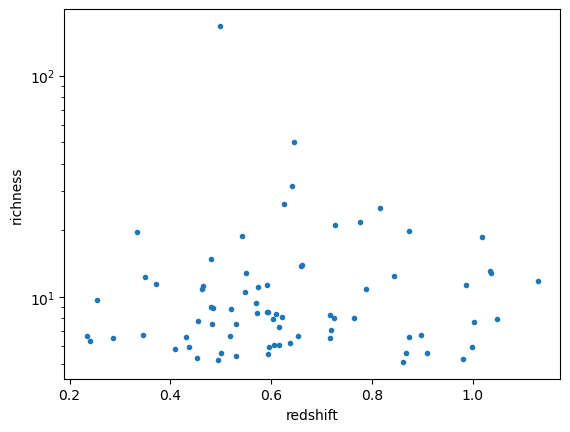

In [33]:
plt.semilogy(dset_in['redshift'][()], dset_in['richness'][()],'.', alpha=1)

plt.xlabel('redshift')
plt.ylabel('richness')

### Open binning output

In [34]:
filename_out = pip_stage.config['cluster_catalog_tomography'] #output_dir + "/cluster_catalog_tomography.hdf5"
print (filename_out)

./data/cosmodc2/outputs-1deg2-CL/cluster_catalog_tomography.hdf5


In [35]:
f_out = h5py.File(filename_out, "r")

In [36]:
print(f_out.keys())

<KeysViewHDF5 ['cluster_bin', 'provenance']>


In [37]:
dat_out = f_out['provenance']
dset_out = f_out['cluster_bin']

In [38]:
print(dset_out.keys())

<KeysViewHDF5 ['bin_zbin_0_richbin_0', 'bin_zbin_0_richbin_1', 'bin_zbin_1_richbin_0', 'bin_zbin_1_richbin_1', 'bin_zbin_2_richbin_0', 'bin_zbin_2_richbin_1']>


In [39]:
[print (i, dict(dset_out[i].attrs), dset_out[i]['redshift'][:].size) for i in dset_out.keys()];

bin_zbin_0_richbin_0 {'rich_max': 10.0, 'rich_min': 5.0, 'z_max': 0.4, 'z_min': 0.2} 5
bin_zbin_0_richbin_1 {'rich_max': 100.0, 'rich_min': 10.0, 'z_max': 0.4, 'z_min': 0.2} 3
bin_zbin_1_richbin_0 {'rich_max': 10.0, 'rich_min': 5.0, 'z_max': 0.6, 'z_min': 0.4} 20
bin_zbin_1_richbin_1 {'rich_max': 100.0, 'rich_min': 10.0, 'z_max': 0.6, 'z_min': 0.4} 8
bin_zbin_2_richbin_0 {'rich_max': 10.0, 'rich_min': 5.0, 'z_max': 0.8, 'z_min': 0.6} 13
bin_zbin_2_richbin_1 {'rich_max': 100.0, 'rich_min': 10.0, 'z_max': 0.8, 'z_min': 0.6} 8


In [40]:
print ([col for col in dset_out['bin_zbin_0_richbin_0']])

['cluster_id', 'dec', 'ra', 'redshift', 'redshift_err', 'richness', 'richness_err', 'scaleval']


In [41]:
print('The file contains',len(dset_out.keys()), 'keys corresponding to',
      len(pip_stage.config.zedge) - 1, ' redshift bins times', 
      len(pip_stage.config.richedge) - 1,'richness bins')

The file contains 6 keys corresponding to 3  redshift bins times 2 richness bins


### Compare the two 

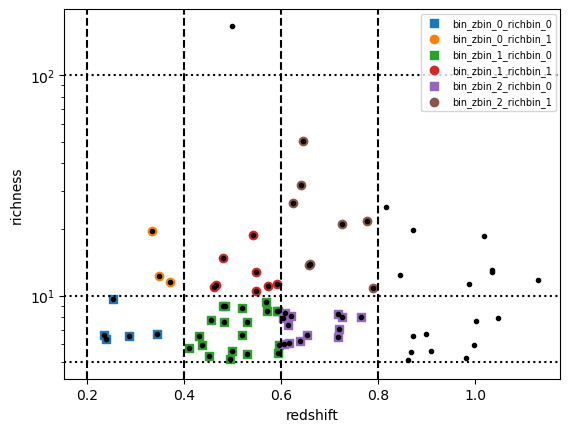

In [42]:
# plot data from input catalog
plt.semilogy(dset_in['redshift'][()], dset_in['richness'][()],'k.', alpha=1)
plt.xlabel('redshift')
plt.ylabel('richness')

# plot bin limits as defined in the config file
[plt.axvline(i,linestyle='dashed', color='black') for i in pip_stage.config.zedge]
[plt.axhline(i,linestyle='dotted', color='black') for i in pip_stage.config.richedge]

# overplot data from output file to make sure the bins are ordered correctly
markers=['s','o', 'D', 'P', '^']

for i in range(len(pip_stage.config.zedge)-1):
    for j in range(len(pip_stage.config.richedge)-1):
        plt.scatter(dset_out['bin_zbin_'+str(i)+'_richbin_'+str(j)]['redshift'][:], 
         dset_out['bin_zbin_'+str(i)+'_richbin_'+str(j)]['richness'][:], marker=markers[j], label='bin_zbin_'+str(i)+'_richbin_'+str(j))
    
    plt.legend(fontsize='x-small')

# II - Now let's do the same using the pipeline approach

Here we will use the 20deg2, but we can also use the 1deg2 files (just need to change 20deg2 to 1deg2 in the name of the files)

### Launching a pipeline

Let's have a look at the submission script for this pipeline:
- to work at CCin2p3 we can use: `examples/cosmodc2/Cluster_pipelines/20deg2-in2p3.sub`
- to work at NERSC we can use: `examples/cosmodc2/Cluster_pipelines/20deg2-nersc.sub`

In [25]:
! cat examples/cosmodc2/Cluster_pipelines/20deg2-in2p3.sub

#!/usr/bin/bash
#SBATCH --time=01:00:00
#SBATCH --partition=hpc
#SBATCH --ntasks=30
#SBATCH --cpus-per-task=1
#SBATCH --mem=128000

source ./conda/bin/activate
export HDF5_DO_MPI_FILE_SYNC=0
ceci examples/cosmodc2/Cluster_pipelines/pipeline-20deg2-CL-in2p3.yml


In [26]:
! cat examples/cosmodc2/Cluster_pipelines/20deg2-nersc.sub

#!/bin/bash
#SBATCH -A m1727
#SBATCH -C cpu
#SBATCH --qos=debug
#SBATCH --time=00:30:00
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=32


module load python
conda activate ./conda
ceci examples/cosmodc2/Cluster_pipelines/pipeline-20deg2-CL-nersc.yml


**The command below will submit a job and run the pipeline**



> **In a terminal, navigate to your TXPipe directory on IN2P3 and run**:
>```
sbatch examples/Cluster_pipelines/cosmodc2/20deg2-in2p3.sub
```


> **If you are ar NERSC, you will instead run**:
>```
sbatch examples/Cluster_pipelines/cosmodc2/20deg2-nersc.sub
```

## Dry-run the pipeline and produce a flowchart plot

The pipeline used here as the other stages commented to only highlight in the flowchart the `CLClusterBinning` stage.
The config file is the same. The file is written for in2p3 but it does not matter as it is a dry-run.

In [38]:
# Read the appropriate pipeline configuration, and ask for a flow-chart.
pipeline_file = "examples/cosmodc2/Cluster_pipelines/CLClusterBinning-20deg2-CL.yml"
flowchart_file = "CLClusterBinning.png"


pipeline_config = ceci.Pipeline.build_config(
    pipeline_file,
    flow_chart=flowchart_file,
    dry_run=True
)

# Run the flow-chart pipeline
ceci.run_pipeline(pipeline_config);

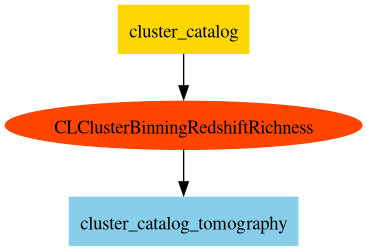

In [39]:
Image(flowchart_file)

## Look at the results

### Open the corresponding pipeline file to load correct input/output file names

In [40]:
with open(pipeline_file, 'r') as file:
    pipeline_content = yaml.safe_load(file)


In [41]:
# open input cluster catalog
filename_in = pipeline_content['inputs']['cluster_catalog']
print(filename_in)
f_in = h5py.File(filename_in, "r")
dset_in = f_in['clusters']

./data/cosmodc2/20deg2/cluster_catalog.hdf5


In [42]:
# open output binning output
filename_out =pipeline_content['output_dir']+"/cluster_catalog_tomography.hdf5"
print (filename_out)
f_out = h5py.File(filename_out, "r")
dat_out = f_out['provenance']
dset_out = f_out['cluster_bin']

./data/cosmodc2/outputs-20deg2-CL/cluster_catalog_tomography.hdf5


### Open the corresponding config file to load config parameters

In [43]:
with open(yaml.safe_load(pipeline_content['config']), 'r') as file:
    config_content = yaml.safe_load(file)

In [44]:
config_bin_info = config_content['CLClusterBinningRedshiftRichness']

### Plot results

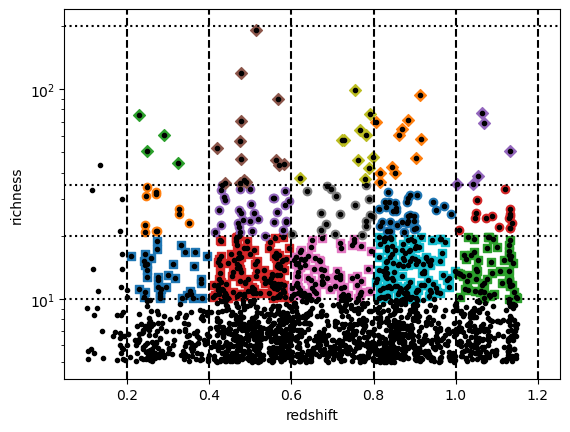

In [45]:
# plot data from input catalog
plt.semilogy(dset_in['redshift'][()], dset_in['richness'][()],'k.', alpha=1)
plt.xlabel('redshift')
plt.ylabel('richness')

# plot bin limits as defined in the config file
[plt.axvline(i,linestyle='dashed', color='black') for i in config_bin_info['zedge']]
[plt.axhline(i,linestyle='dotted', color='black') for i in config_bin_info['richedge']]

# overplot data from output file to make sure the bins are ordered correctly
markers=['s','o', 'D', 'P', '^']

for i in range(len(config_bin_info['zedge'])-1):
    for j in range(len(config_bin_info['richedge'])-1):
        plt.scatter(dset_out['bin_zbin_'+str(i)+'_richbin_'+str(j)]['redshift'][:], 
         dset_out['bin_zbin_'+str(i)+'_richbin_'+str(j)]['richness'][:], marker=markers[j], label='bin_zbin_'+str(i)+'_richbin_'+str(j))
    
    #plt.legend(fontsize='x-small')

In [46]:
dset_out['bin_zbin_0_richbin_2']['cluster_id'][:]

array([ 391.,  623., 1000., 1166.])

In [47]:
dset_out['bin_zbin_0_richbin_2']['redshift'][:]

array([0.22806019, 0.28845891, 0.24925604, 0.3245388 ])